Data Preprocessing

In [1]:
import gc
import os
import nltk
import tqdm
import numpy as np
import pandas as pd
import ipdb
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Model Imports

In [10]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine import Layer
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten
from keras.layers import concatenate, GRU, Input, K, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
from gensim.models.keyedvectors import KeyedVectors
embed_model = KeyedVectors.load_word2vec_format('/opt/flask/src/Flask_Core/Nltk/Data/flaskwordembeddings/word2vec.100B.300d.bin', binary=True)
embed_model_txt = embed_model.save_word2vec_format('/opt/flask/src/Flask_Core/Nltk/Data/flaskwordembeddings/word2vec.100B.300d.txt', binary=False)

In [3]:
def read_embedding_list(file_path):
    embedding_word_dict = {}
    embedding_list = []
    f = open(file_path)
    
    for index, line in enumerate(f):
        if index == 0:
            continue
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            continue
        embedding_list.append(coefs)
        embedding_word_dict[word] = len(embedding_word_dict)
    f.close()
    embedding_list = np.array(embedding_list)
    return embedding_list, embedding_word_dict

In [4]:
#Embedding
print("Loading Embeddings...")
embedding_list, embedding_word_dict = read_embedding_list('/opt/flask/src/Flask_Core/Nltk/Data/flaskwordembeddings/word2vec.100B.300d.txt')
embedding_size = len(embedding_list[0])

Loading Embeddings...


In [5]:
def tokenize_sentences(sentences, words_dict):
    tokenized_sentences = []
    for sentence in tqdm.tqdm(sentences):
        if hasattr(sentence, "decode"):
            sentence = sentence.decode("utf-8")
        tokens = nltk.tokenize.word_tokenize(sentence)
        result = []
        for word in tokens:
            word = word.lower()
            if word not in words_dict:
                words_dict[word] = len(words_dict)
            word_index = words_dict[word]
            result.append(word_index)
        tokenized_sentences.append(result)
    return tokenized_sentences, words_dict

In [6]:
def clear_embedding_list(embedding_list, embedding_word_dict, words_dict):
    cleared_embedding_list = []
    cleared_embedding_word_dict = {}
    
    for word in words_dict:
        if word not in embedding_word_dict:
            continue
        word_id = embedding_word_dict[word]
        row = embedding_list[word_id]
        cleared_embedding_list.append(row)
        cleared_embedding_word_dict[word] = len(cleared_embedding_word_dict)
        
    return cleared_embedding_list, cleared_embedding_word_dict

In [7]:
def convert_tokens_to_ids(tokenized_sentences, words_list, embedding_word_dict, sentences_length):
    words_train = []
    
    for sentence in tokenized_sentences:
        current_words = []
        for word_index in sentence:
            word = words_list[word_index]
            word_id = embedding_word_dict.get(word, len(embedding_word_dict)-2)
            current_words.append(word_id)
        if len(current_words) >= sentences_length:
            current_words = current_words[:sentences_length]
        else:
            current_words += [len(embedding_word_dict)-1]*(sentences_length-len(current_words))
            
        words_train.append(current_words)
    return words_train

Reading, Preprocessing and Preparing Training Data

In [25]:
sentences_length = 60
print("Loading Data...")
train_df = pd.read_csv('/opt/flask/src/Flask_Core/Nltk/Data/Datasets/train_full_training_datathon3_5_70_percent_monday_loop.csv')
#validation_df = pd.read_csv('/opt/flask/src/Flask_Core/Nltk/Data/Datasets/validation_full_training_datathon3_5_70_percent_monday_loop.csv')
print(f"Number of training items: {len(train_df)}")
num_classes = np.unique(train_df['Label'])
print(f"Total number of classes:{num_classes}")

print("Tokenizing sentences in train set...")
tokenized_senteces_train, words_dict = tokenize_sentences(train_df['Text'], {})

print("Preparing Training data...")
embedding_list, embedding_word_dict = clear_embedding_list(embedding_list, embedding_word_dict, words_dict)

embedding_list.append([0.] * embedding_size)
embedding_list.append([-1.] * embedding_size)

embedding_matrix = np.array(embedding_list)

id_to_word = dict((id, word) for word, id in words_dict.items())
train_list_of_tokens_ids = convert_tokens_to_ids(tokenized_senteces_train, id_to_word, embedding_word_dict, sentences_length)

X_train = np.array(train_list_of_tokens_ids)
y_train = to_categorical(np.asarray(train_df['Label']))

print(f'Print train data shape: {X_train.shape}\nPrint train label shape: {y_train.shape}')
num_classes = len(np.unique(train_df['Label']))

 32%|███▏      | 783/2457 [00:00<00:00, 7827.54it/s]

Loading Data...
Number of training items: 2457
Total number of classes:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Tokenizing sentences in train set...


100%|██████████| 2457/2457 [00:00<00:00, 7862.98it/s]

Preparing Training data...
Print train data shape: (2457, 60)
Print train label shape: (2457, 32)


In [27]:
y_train.shape[1]

32

In [12]:
batch_size = 32
dropout_rate = 0.2
fold_count = 2
gru_len = 128
routings = 5
num_capsule = 10
dim_capsule = 16
kernel_size = (3,3)

In [13]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm+K.epsilon())
    return x/scale

In [14]:
class Capsule(Layer):
    def __init__(self, num_capsule=10, dim_capsule=16, routing=3, kernel_size=(9,1), share_weights=True, activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)
    
    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel', shape=(1, input_dim_capsule, self.num_capsule*self.dim_capsule), initializer='glorot_uniform', trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(nmae='capsule_kernel', shape=(input_num_capsule, input_dim_capsule, self.num_capsule*self.dim_capsule),initializer='glorot_uniform', trainable=True)
    
    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])
            
        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0,2,1,3))
        
        b = K.zeros_like(u_hat_vecs[:,:,:,0]) #shape = [None, num_capsule, input_num_capsule]
        
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1)) #shape = [None, input_num_capsule, num_capsule]
            
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0,2,1))
            b = K.permute_dimensions(b, (0,2,1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2,2]))
            if i < self.routings -1:
                b = K.batch_dot(outputs, u_hat_vecs, [2,3])
        return outputs
    
    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [28]:
def get_model(embedding_matrix, sequence_length, dropout_rate):
    input1 = Input(shape=(sequence_length,))
    embed_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], trainable=False)(input1)
    embed_layer = SpatialDropout1D(dropout_rate)(embed_layer)
    x = Bidirectional(GRU(gru_len, activation='relu', dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True))(embed_layer)
    capsule = Capsule(num_capsule=num_capsule, dim_capsule=dim_capsule, routing=routings, kernel_size=kernel_size, share_weights=True)(x)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_rate)(capsule)
    ipdb.set_trace()
    output = Dense(num_classes, activation='softmax')(capsule)
    model = Model(inputs=input1, outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
    model.summary()
    return model

Training Model

In [29]:
def _train_model(model, batch_size, train_x, train_y, val_x, val_y):
    num_labels =  y_train.shape[1]
    patience = 5
    best_loss = -1
    best_weights = None
    best_epochs = 0
    
    current_epoch = 0
    
    while True:
        model.fit(train_x, train_y, batch_size=batch_size, epochs=1, validation_data=(val_x, val_y))
        y_pred = model.predict(val_x, batch_size=batch_size)
        total_loss = 0
        #ipdb.set_trace()
        for j in range(num_labels):
            loss = log_loss(val_y[:, j], y_pred[:, j])
            total_loss += loss
        total_loss /=num_labels
            
        print(f"Epoch{current_epoch}\n loss{total_loss}\n best_loss:{best_loss}")
                
        current_epoch += 1
        if total_loss < best_loss or best_loss == -1:
            best_loss = total_loss
            best_weights = model.get_weights()
            best_epoch = current_epoch
        else:
            if current_epoch - best_epoch == patience:
                break
                  
    model.set_weights(best_weights)
    return model
                

In [30]:
def train_folds(X, y, fold_count, batch_size, get_model_func):
    print("="*75)
    fold_size = len(X) // fold_count
    model = []
    result_path = "predictions"
    if not os.path.exists(result_path):
        os.mkdir(result_path)
    for fold_id in range(0, fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        
        
        if fold_id == fold_size -1:
            fold_end = len(X)
        #ipdb.set_trace()
        train_x = np.concatenate([X[:fold_start], X[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])
        
        val_x = np.array(X[fold_start:fold_end])
        val_y = np.array(y[fold_start:fold_end])
        
        model = _train_model(get_model_func(), batch_size, train_x, train_y, val_x, val_y)
        train_predicts_path = os.path.join(result_path, "train_predicts{0}.npy".format(fold_id))
        
        test_predicts_path = os.path.join(result_path, "test_predicts{0}.npy".format(fold_id))
        train_predicts = model.predict(X, batch_size=32, verbose=1)
        #test_predicts = model.predict(X_test, batch_size=32, verbose=1)
        np.save(train_predicts_path, train_predicts)
        #np.save(test_predicts_path, test_predicts)
        
    return model

In [31]:
get_model_func = lambda: get_model(embedding_matrix, sentences_length, dropout_rate)

In [32]:
models = train_folds(X_train, y_train, fold_count, batch_size, get_model_func)

> <ipython-input-28-4625a199ad52>(10)get_model()
      9     ipdb.set_trace()
---> 10     output = Dense(num_classes, activation='softmax')(capsule)
     11     model = Model(inputs=input1, outputs=output)

ipdb> c
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 300)           752400    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 60, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 256)           329472    
_________________________________________________________________
capsule_3 (Capsule)          (None, 10, 16)            40960     
___________________________________________________________

ipdb> c
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 60, 300)           752400    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 60, 300)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60, 256)           329472    
_________________________________________________________________
capsule_4 (Capsule)          (None, 10, 16)            40960     
_________________________________________________________________
flatten_4 (Flatten)          (None, 160)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 160)               0         
__

Epoch27
 loss0.055672968921712876
 best_loss:0.054515268946123456
2457/2457 [==============================] - 6s 2ms/step


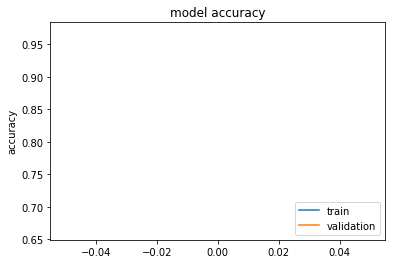

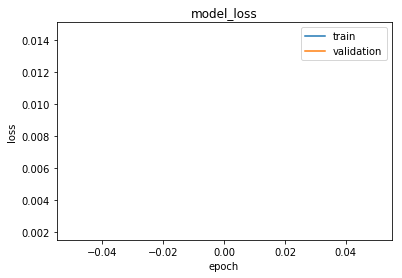

In [46]:
#summarize history for accuracy
plt.plot(models.history.history['acc'])
plt.plot(models.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc='lower right')
plt.show()
#summarize history for loss
plt.plot(models.history.history['loss'])
plt.plot(models.history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Saving_model

In [196]:
model_name = 'Capsule_Network'
saving_path = '/opt/flask/src/Flask_Core/Nltk/Data/TrainedModels/'

In [197]:
import pickle

In [201]:
models.save(saving_path + model_name + '.h5')

with open(saving_path +'utils_'+ model_name +'.pickle', 'wb') as f:
    pickle.dump((embedding_matrix, sentences_length, num_classes, num_capsule, dim_capsule, dropout_rate), f)

Loading and Unpickling Model

In [211]:
with open (saving_path + 'utils_'+ model_name+'.pickle', 'rb') as f:
    pred_embedding_matrix, pred_num_classes, pred_sentences_length, pred_num_capsule, pred_dim_capsule, pred_dropout_rate, = pickle.load(f)

loaded_model = load_model(saving_path + model_name +'.h5', custom_objects={'Capsule':Capsule(pred_num_capsule, pred_dim_capsule)})

Testing

In [224]:
print("Preparing Testing data...")
test_df = pd.read_csv('/opt/flask/src/Flask_Core/Nltk/Data/Datasets/thirty_percent_for_testing_data.csv')
print(f"Number of testing items{len(test_df)}")
print("Preprocessing sentences in test set...")

tokenized_sentences_test, words_dict = tokenize_sentences(test_df['Text'], words_dict)

test_list_of_tokens_ids = convert_tokens_to_ids(tokenized_sentences_test, id_to_word, embedding_word_dict, sentences_length)

X_test = np.array(test_list_of_tokens_ids)
y_test = np.asarray(test_df['Label'])

print(f'Print train data shape: {X_test.shape}\nPrint train label shape: {y_test.shape}')

100%|██████████| 141/141 [00:00<00:00, 6426.55it/s]

Preparing Testing data...
Number of testing items141
Preprocessing sentences in test set...
Print train data shape: (141, 60)
Print train label shape: (141,)


In [225]:
test_predictions_probs = loaded_model.predict(X_test)
test_predictions = test_predictions_probs.argmax(axis=-1)

Metrics and Score

In [227]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [228]:
print(f'accuracy: {sum(test_predictions == y_test)/len(y_test)}')
print("Precision, Recall and F1-Score:\n\n", classification_report(y_test, test_predictions))

accuracy: 0.524822695035461
Precision, Recall and F1-Score:

               precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.67      0.40      0.50         5
           2       0.57      0.80      0.67         5
           3       0.40      1.00      0.57         2
           4       0.60      0.60      0.60         5
           5       0.50      1.00      0.67         2
           6       1.00      0.71      0.83         7
           7       1.00      0.60      0.75         5
           8       0.00      0.00      0.00         2
           9       1.00      0.40      0.57         5
          10       0.20      0.25      0.22         4
          11       0.50      1.00      0.67         1
          12       0.57      0.89      0.70         9
          13       0.00      0.00      0.00         4
          14       0.33      0.25      0.29         4
          15       0.50      0.25      0.33         4
          16       

In [229]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [230]:
class_names, class_count = np.unique(test_df['Label'], return_counts=True)

Confusion matrix, without normalization


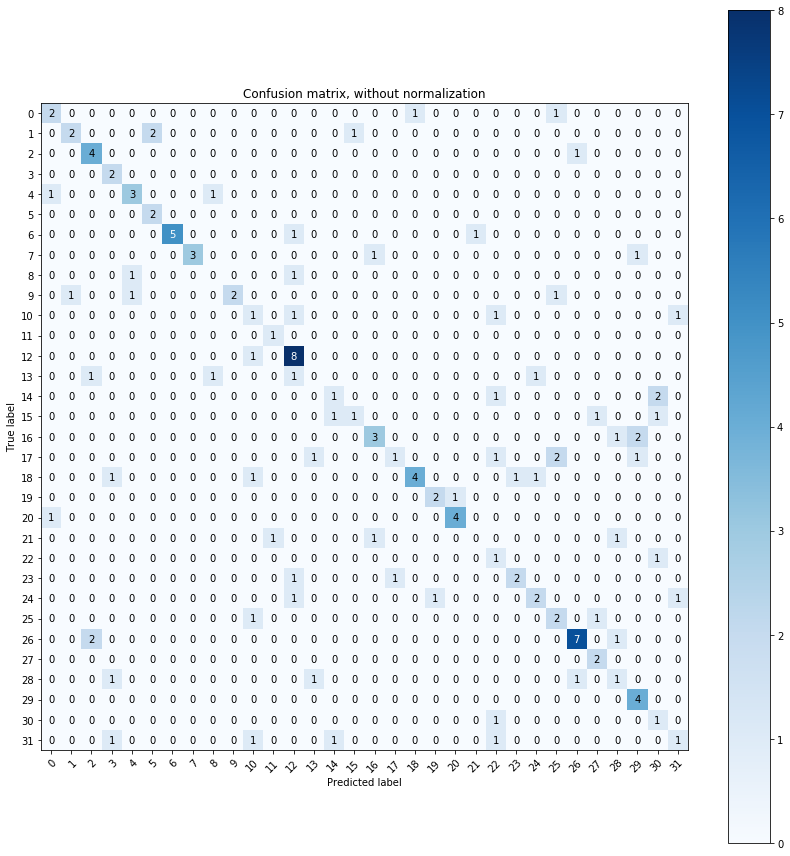

In [231]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, test_predictions, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(test_intent_original, test_intent_predictions, classes=test_df['String_label'], normalize=True,
#                       title='Normalized confusion matrix')

plt.show()